# Cellpose Segmentation on human protein atlas images

In [2]:
import os

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection
import scportrait

In [3]:
project_location = "project"
config_path = scportrait.data.get_config_file(config_id = "dataset_2_config")
project = Project(
    os.path.abspath(project_location),
    config_path=config_path,
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Downloading...: 1.57kB [00:00, 2.48MB/s]                 


Updating project config file.
[10/04/2025 19:03:09] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/config.yml
[10/04/2025 19:03:09] Compression algorithm for extracted single-cell images: lzf
[10/04/2025 19:03:09] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2.
[10/04/2025 19:03:09] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2.


In [4]:
dataset_2_path = scportrait.data.dataset_2()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_2_path}/Ch1.tif", f"{dataset_2_path}/Ch2.tif", f"{dataset_2_path }/Ch3.tif"]

project.load_input_from_tif_files(images, channel_names = ["Channel1", "Channel2", "Channel3"])

[10/04/2025 19:03:09] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/scportrait
         .sdata                                                                                                    


[10/04/2025 19:03:09] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/Project_hdt2zmjo for Project
[10/04/2025 19:03:09] Image input_image written to sdata object.
[10/04/2025 19:03:10] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/Project_hdt2zmjo'>


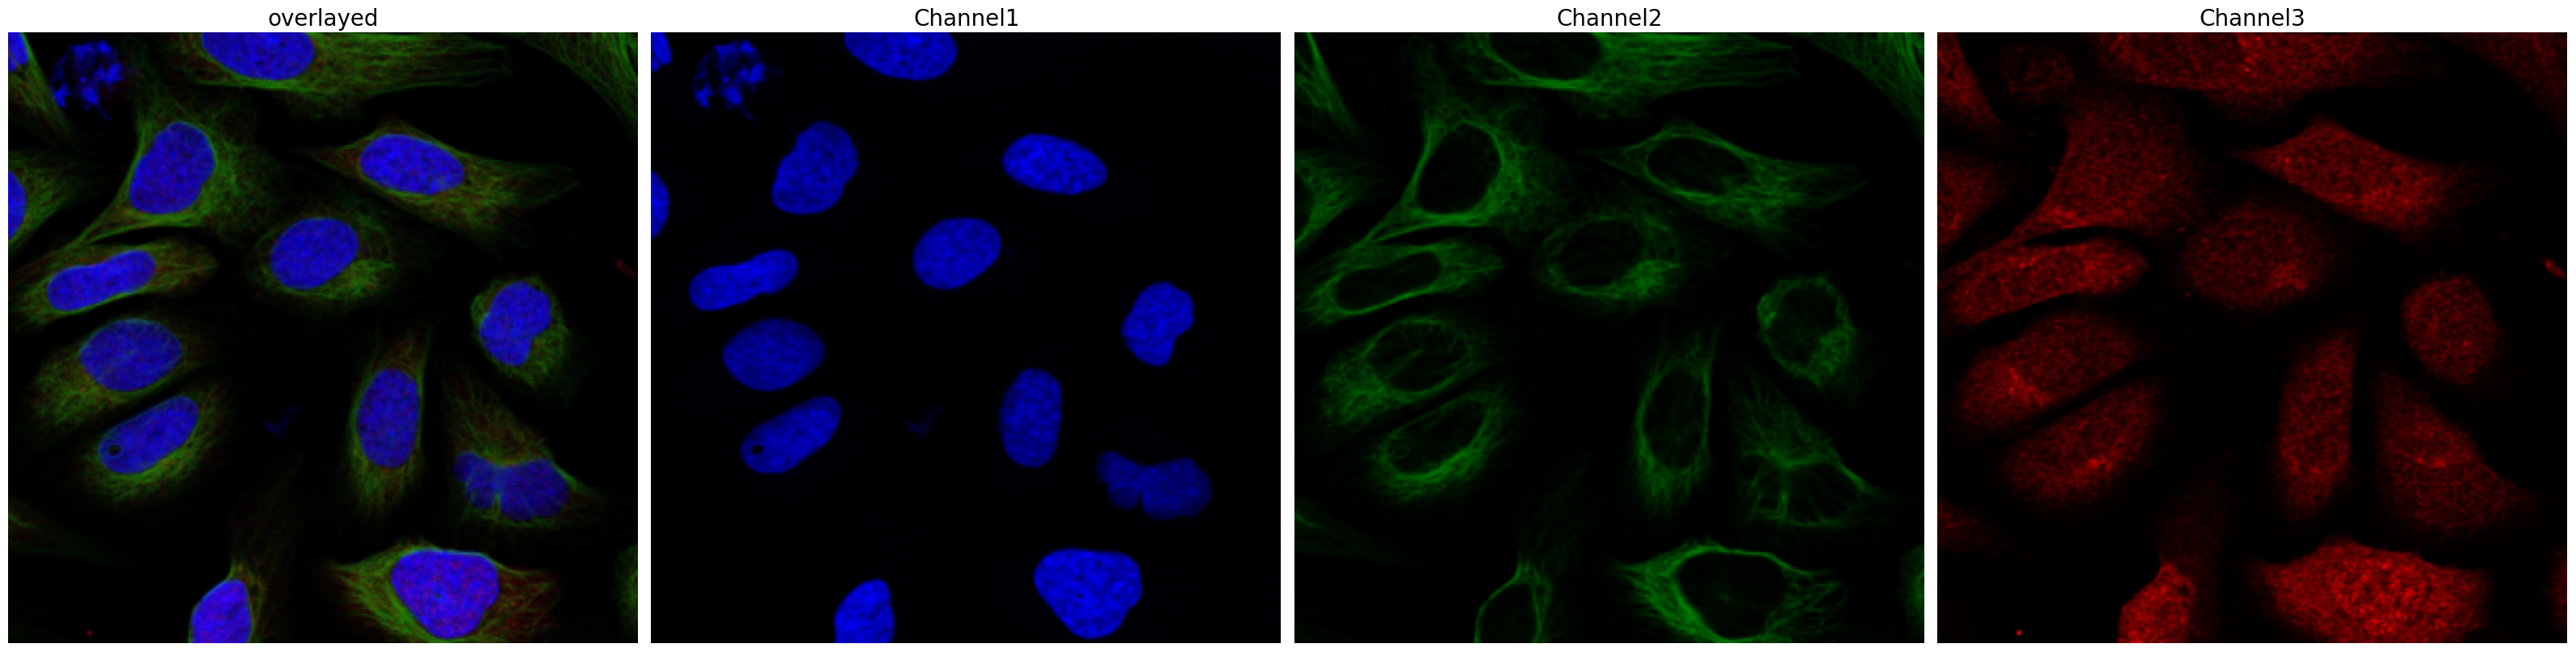

In [5]:
project.plot_input_image()

[10/04/2025 19:03:13] GPU Status for segmentation is True and will segment using the following device mps.
[10/04/2025 19:03:13] Segmenting nucleus using the following model: nuclei
[10/04/2025 19:03:16] Segmenting cytosol using the following model: cyto2
[10/04/2025 19:03:16] Performing filtering to match Cytosol and Nucleus IDs.
[10/04/2025 19:03:16] Removed 4 nuclei and 2 cytosols due to filtering.
[10/04/2025 19:03:16] After filtering, 7 matching nuclei and cytosol masks remain.
[10/04/2025 19:03:17] Total time to perform nucleus and cytosol mask matching filtering: 0.59 seconds
[10/04/2025 19:03:17] Segmentation seg_all_nucleus written to sdata object.
[10/04/2025 19:03:18] Points centers_seg_all_nucleus written to sdata object.
[10/04/2025 19:03:18] Segmentation seg_all_cytosol written to sdata object.
[10/04/2025 19:03:19] Points centers_seg_all_cytosol written to sdata object.


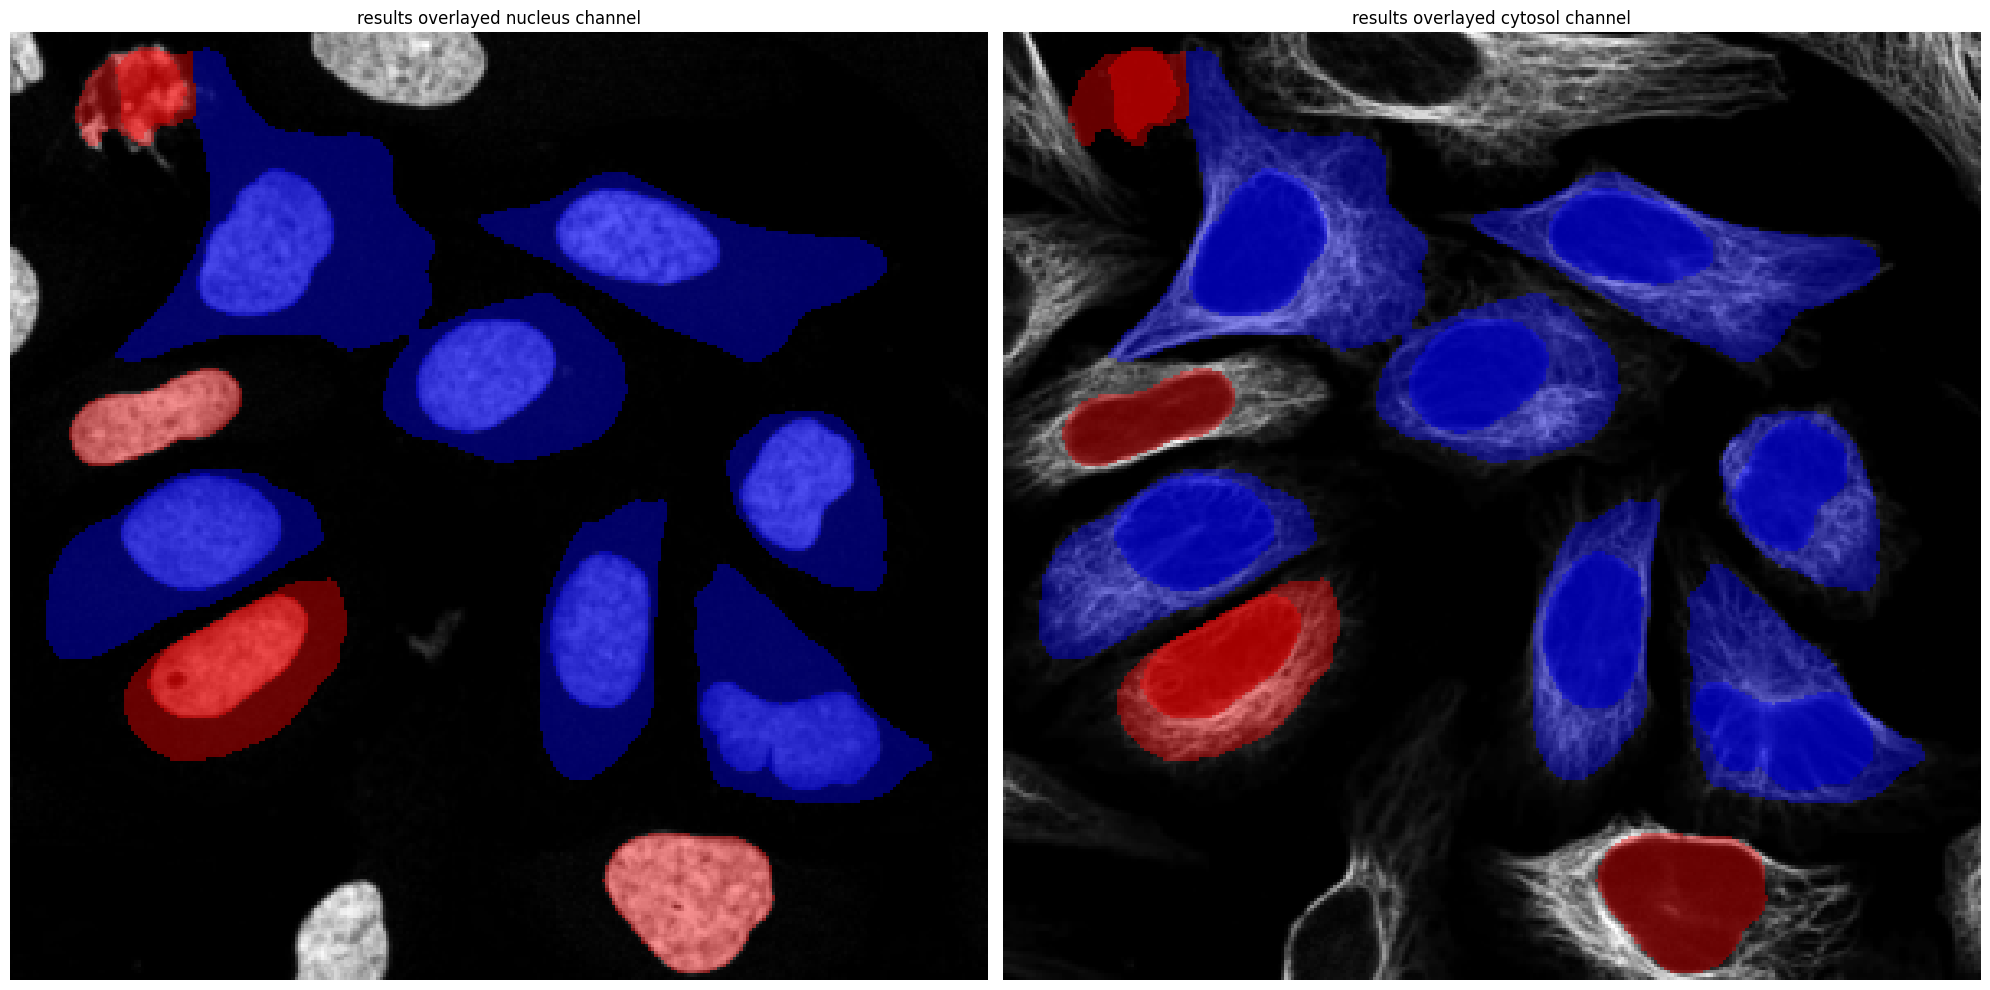

In [6]:
project.segment()

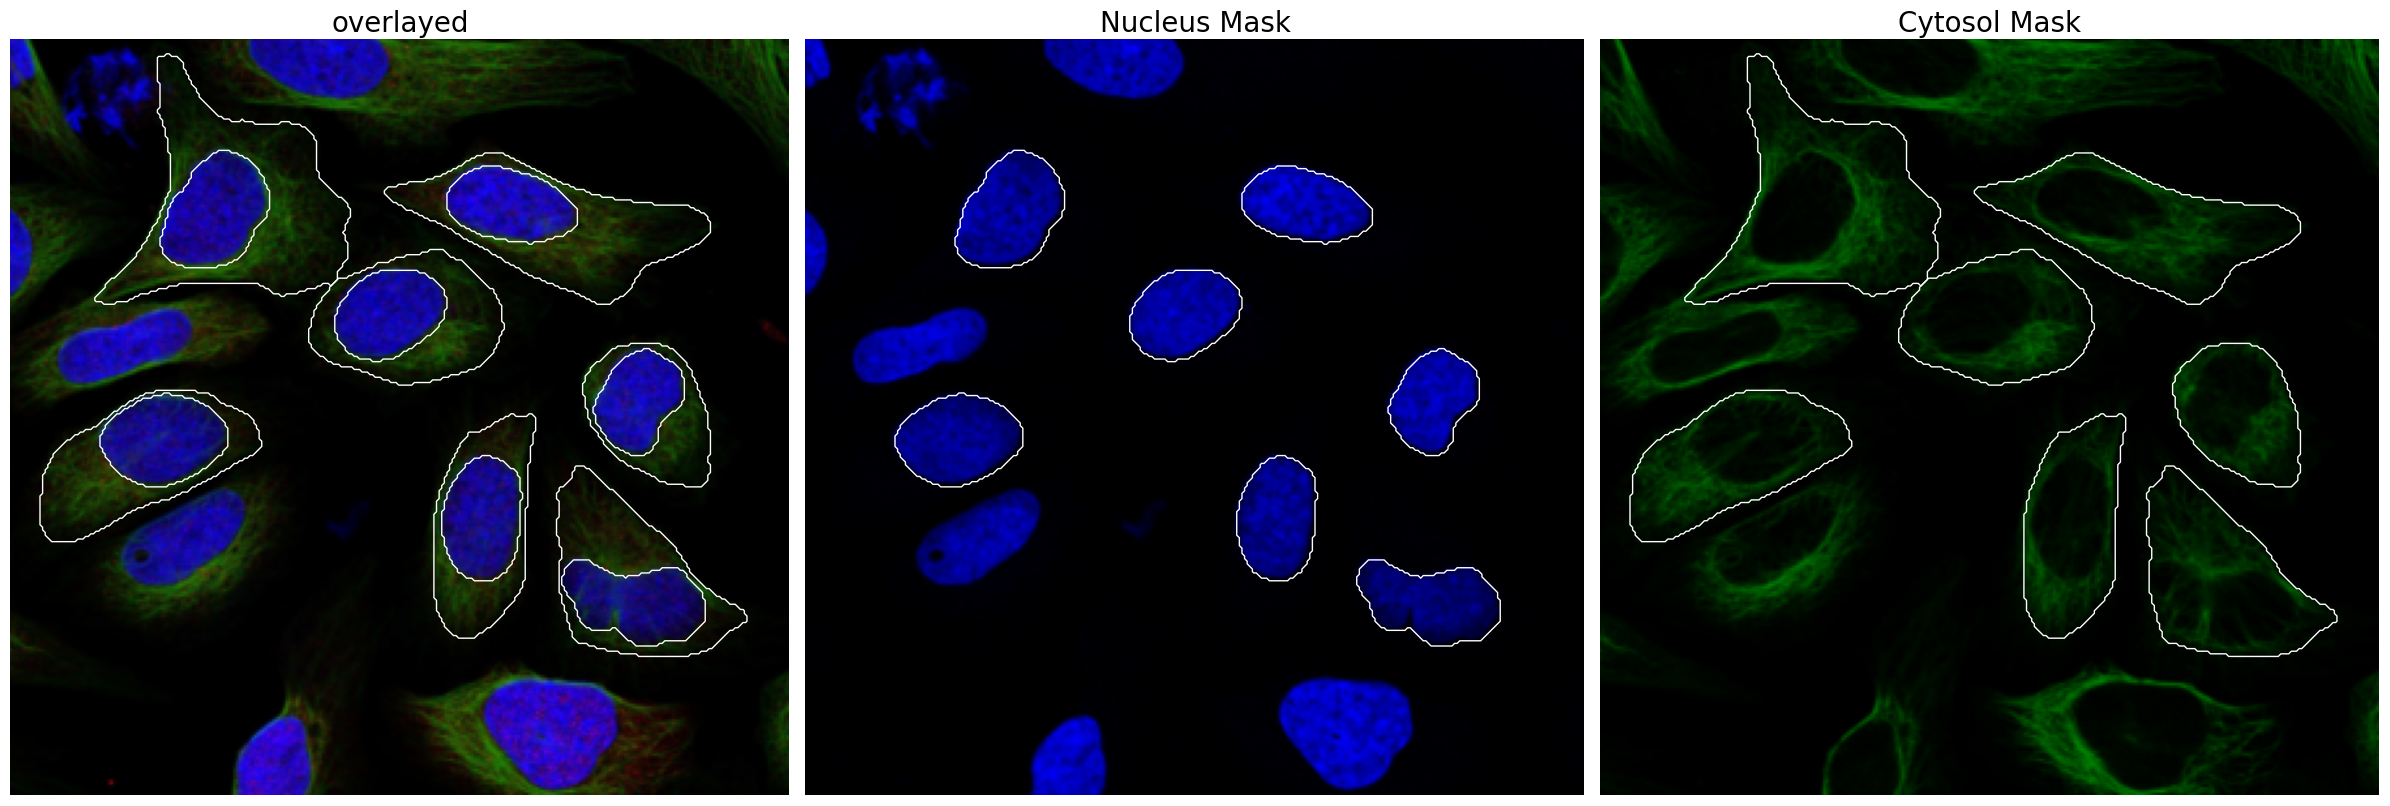

In [7]:
project.plot_segmentation_masks()

In [8]:
project.extract()

[10/04/2025 19:03:20] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_h_kn4vdv for HDF5CellExtraction
[10/04/2025 19:03:20] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data
[10/04/2025 19:03:20] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data
[10/04/2025 19:03:20] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[10/04/2025 19:03:20] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[10/04/2025 19:03:20] A total of 0 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/p

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

[10/04/2025 19:03:21] Finished extraction in 0.15 seconds (47.90 cells / second)
[10/04/2025 19:03:21] Benchmarking times saved to file.
[10/04/2025 19:03:21] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_h_kn4vdv'>


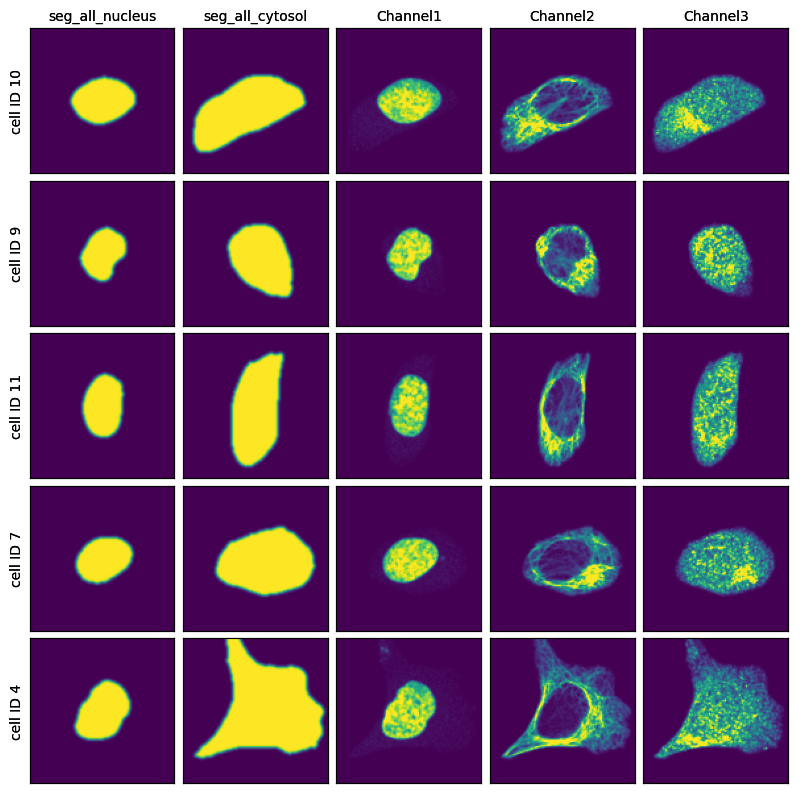

In [9]:
project.plot_single_cell_images()

In [10]:
project.featurize(overwrite=True)

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data/single_cells.h5sc
[10/04/2025 19:03:22] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/CellFeaturizer_47gg1_ai for CellFeaturizer
[10/04/2025 19:03:22] Started CellFeaturization of all available channels.
[10/04/2025 19:03:22] Overwrite flag is set, deleting existing directory for featurization results.
[10/04/2025 19:03:22] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/featurization/complete_CellFeaturizer
[10/04/2025 19:03:22] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[10/04/2025 19:03:22] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/Ce

In [11]:
# load classification results
results = project.sdata['CellFeaturizer_cytosol'].to_df().merge(project.sdata['CellFeaturizer_cytosol'].obs, left_index=True, right_index=True).drop(columns = "region")
results

,nucleus_area,cytosol_area,cytosol_only_area,Channel1_mean_nucleus,Channel1_median_nucleus,Channel1_quant75_nucleus,Channel1_quant25_nucleus,Channel1_summed_intensity_nucleus,Channel1_summed_intensity_area_normalized_nucleus,Channel1_mean_cytosol,...,Channel3_quant25_cytosol,Channel3_summed_intensity_cytosol,Channel3_summed_intensity_area_normalized_cytosol,Channel3_mean_cytosol_only,Channel3_median_cytosol_only,Channel3_quant75_cytosol_only,Channel3_quant25_cytosol_only,Channel3_summed_intensity_cytosol_only,Channel3_summed_intensity_area_normalized_cytosol_only,scportrait_cell_id
0,2043.0,6255.0,4212.0,0.093840,0.0,0.024887,0.0,1135.460449,0.269578,0.093840,...,0.0,2101.005859,0.498814,0.173637,0.0,0.315674,0.0,2101.005859,0.498814,4
1,1746.0,4319.0,2573.0,0.073899,0.0,0.007010,0.0,894.177795,0.347523,0.073899,...,0.0,1735.827393,0.674632,0.143457,0.0,0.119019,0.0,1735.827393,0.674632,5
2,1768.0,3839.0,2071.0,0.079282,0.0,0.001667,0.0,959.311768,0.463212,0.079282,...,0.0,1442.796143,0.696666,0.119239,0.0,0.028942,0.0,1442.796143,0.696666,7
3,1586.0,2841.0,1255.0,0.067117,0.0,0.000000,0.0,812.111816,0.647101,0.067117,...,0.0,1124.324585,0.895876,0.092919,0.0,0.000000,0.0,1124.324585,0.895876,9
4,1972.0,4059.0,2087.0,0.086109,0.0,0.003860,0.0,1041.914307,0.499240,0.086109,...,0.0,1476.587402,0.707517,0.122032,0.0,0.053192,0.0,1476.587402,0.707517,10
5,1820.0,3528.0,1708.0,0.076221,0.0,0.000010,0.0,922.273682,0.539973,0.076221,...,0.0,1457.363647,0.853257,0.120443,0.0,0.000201,0.0,1457.363647,0.853257,11
6,2014.0,4259.0,2245.0,0.080958,0.0,0.008331,0.0,979.588989,0.436343,0.080958,...,0.0,1587.135742,0.706965,0.131168,0.0,0.135986,0.0,1587.135742,0.706965,13
